In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.efficientnet import EfficientNetB3

### Problem
The goal of this problem is to train a neural network to categorize pictures of flowers into 1 of 5 categories: Daisies, Dandelions, Roses, Sunflowers, and Tulips.

This will be using a dataset of flower images taken from Kaggle: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset/data

### EDA
Starting by importing the photos. The photos come in 5 folders (for each flower type), so I want to add them to the dataframe with the filename in one column, and the label (folder name) in the 2nd column. There are 3670 photos in total.

In [74]:
image_dir = ["flower_photos"]

data = []

for flower_dir in image_dir:

        for subdir, _, files in os.walk(flower_dir):
            label = os.path.basename(subdir)  
            for file in files:
                file_path = os.path.join(subdir, file)
                data.append([file_path, label])
                
label_df = pd.DataFrame(data, columns=['file', 'label'])

print(label_df.info())
print(label_df.columns)
label_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    3670 non-null   object
 1   label   3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB
None
Index(['file', 'label'], dtype='object')


,file,label
0,flower_photos/roses/16209331331_343c899d38.jpg,roses
1,flower_photos/roses/5777669976_a205f61e5b.jpg,roses
2,flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg,roses
3,flower_photos/roses/15011625580_7974c44bce.jpg,roses
4,flower_photos/roses/17953368844_be3d18cf30_m.jpg,roses


Since I'm making the dataframe myself, I don't really need to worry about checking for incorrect/null data. I do want to check the distribution of pictures to make sure it's relatively even. Looking at the graph, there's a bit of a gap between the number of dandelions and the others, but overall it's relatively even.

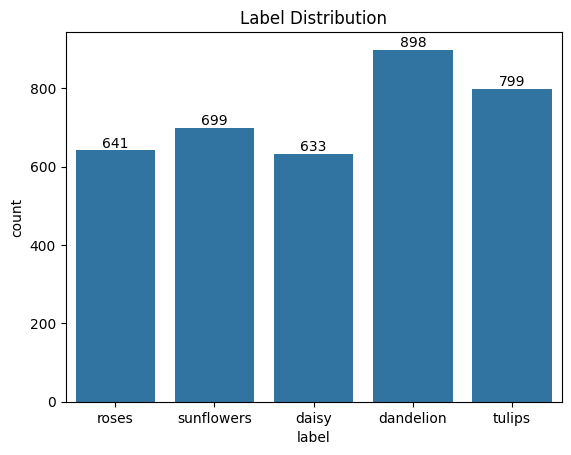

In [65]:
# Label Distribution
ax = sns.countplot(x='label', data=label_df)
ax.bar_label(ax.containers[0])
plt.title('Label Distribution')
plt.show()

Next I'll take a look at some example images for each. One thing to note is that images are not all the same size, so I'll need to handle that somehow.

['roses' 'sunflowers' 'daisy' 'dandelion' 'tulips']


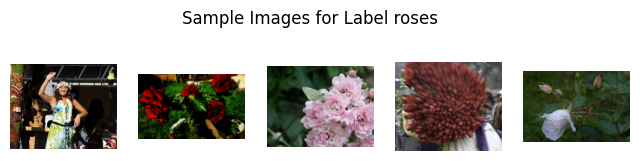

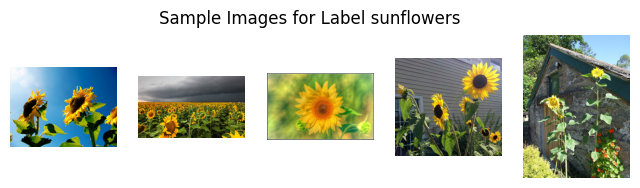

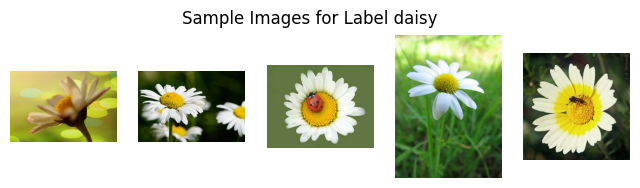

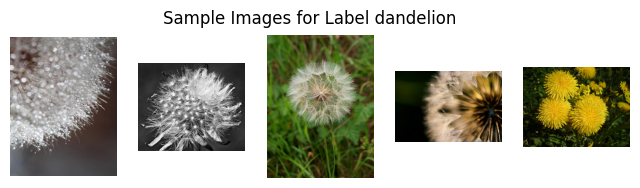

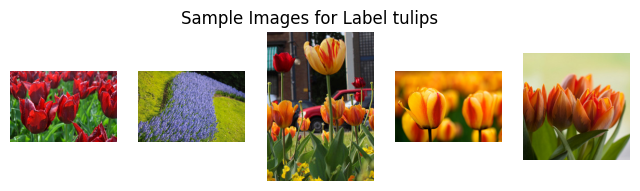

Different Image Sizes:  {(500, 332), (320, 213), (320, 264), (500, 292), (180, 240), (500, 305), (500, 417), (320, 250), (172, 240), (500, 333), (320, 256), (320, 240), (240, 221), (185, 240), (500, 313), (240, 240)}


In [75]:
sizes = set()

label_names = label_df['label'].unique()
print(label_names)

def sample_images(label, num_samples=3):
    sample_images = label_df[label_df['label'] == str(label)].sample(num_samples)
    plt.figure(figsize=(8, 2))
    
    for i, filename in enumerate(sample_images['file']):
        img_path = os.path.join(filename)
        img = Image.open(img_path)
        sizes.add(img.size)
        plt.subplot(1, num_samples, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
        
    plt.suptitle(f'Sample Images for Label {label}') 
    plt.show()

for l in label_names:
    sample_images(l, 5)
print("Different Image Sizes: ", sizes)

I'll prepare the images for training and split them into training/validation sets. I'll resize all the images so they're consistent, and add some modifiers to the training data.

In [119]:
# Augmenting the data for training
t_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
v_datagen = ImageDataGenerator(rescale=1/255.0)

Then I'll split the data into the training/validation sets. I'll set the target sizes so they're all the same shape, and use a batch size of 32 for now.

In [120]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(label_df, test_size=0.2, stratify=label_df['label'], random_state=42)

train_generator = t_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True,
    seed=10,
    # subset='training'
)

val_generator = v_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col='file',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= False,
    seed=10,
    # subset='validation'
)

Found 2936 validated image filenames belonging to 5 classes.
Found 734 validated image filenames belonging to 5 classes.


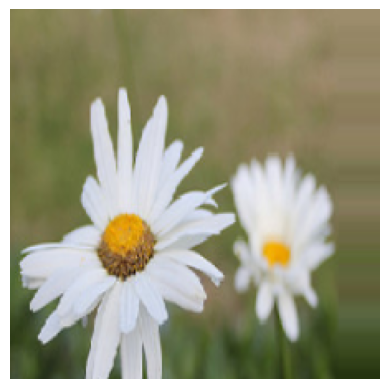

In [106]:
# Checking that images aren't overly distorted
img, label = next(train_generator)    
plt.imshow(img[0])
plt.axis('off')
    
plt.show()

### Building the Models

#### Model 1
First I'll start of with a basic model, with 3 convolution layers with pooling in between, and ending with Softmax for the activation since I need it to return a multiclass output.

In [142]:
# Basic Model:
def basic_CNN():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dense(5, activation='softmax')
    ])
    return model

basic_model = basic_CNN()
basic_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │    88,604,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,699,461 (338.36 MB)

 Trainable params: 88,699,461 (338.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling Models

In [171]:
def fit_model(lr, epochs, model):
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(lr),
                 metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('best_model.h5.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, baseline=None)
    
    return model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping]
    )
def plot_stats(history, title, acc_range=[.2, 1], loss_range=[0,2]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(history.history['accuracy'], label='accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(acc_range)
    ax1.set_title(title)
    ax1.legend(loc='lower right')
    
    ax2.plot(history.history['loss'], label='loss')
    ax2.plot(history.history['val_loss'], label = 'val_loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_ylim(loss_range)
    ax2.set_title(title)
    ax2.legend(loc='lower right')


### Hyperparameter Tuning

In [ ]:
# placeholder

### Analysis + Conclusion

In [136]:
LEARN_RATE = .0001
optimizer = tf.keras.optimizers.Adam(LEARN_RATE)
basic_model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [112]:


checkpoint = ModelCheckpoint('best_model.h5.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, baseline=None)

history = basic_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    # validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

print("Completed")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 518ms/step - accuracy: 0.3434 - loss: 1.5330 - val_accuracy: 0.5341 - val_loss: 1.1190
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - accuracy: 0.5386 - loss: 1.1158 - val_accuracy: 0.5109 - val_loss: 1.1722
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 52s 560ms/step - accuracy: 0.5971 - loss: 1.0672 - val_accuracy: 0.5940 - val_loss: 0.9900
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 513ms/step - accuracy: 0.6175 - loss: 1.0146 - val_accuracy: 0.6267 - val_loss: 0.9578
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 517ms/step - accuracy: 0.6329 - loss: 0.9654 - val_accuracy: 0.6390 - val_loss: 0.8916
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 514ms/step - accuracy: 0.6521 - loss: 0.9090 - val_accuracy: 0.6826 - val_loss: 0.8770
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 516ms/step - accuracy: 0.6829 - loss: 0.8463 - val_accuracy: 0.6866 - val_loss: 0.8287
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 512ms/step - accuracy: 0.6694 - loss: 0.8724 - val_accu

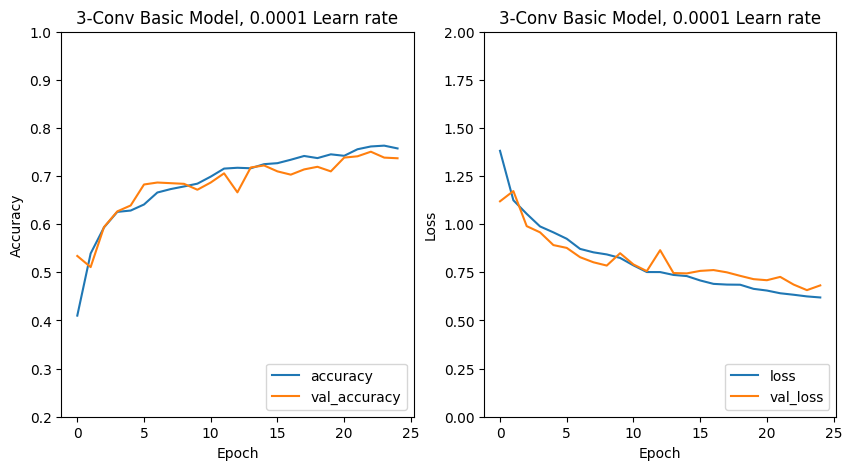

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.2, 1])
ax1.set_title('3-Conv Basic Model, 0.0001 Learn rate')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2])
ax2.set_title('3-Conv Basic Model, 0.0001 Learn rate')
ax2.legend(loc='lower right')


From this first run, we can see that it's taking a while to converge. While increasing the epoch count would likely work, I first want to try a higher learning rate and seeing if that helps converge faster, so I'll try the same model with a .001 learning rate instead and see how it goes.

In [138]:
LEARN_RATE = .001
optimizer2 = tf.keras.optimizers.Adam(LEARN_RATE)
basic_model.compile(loss='categorical_crossentropy',
             optimizer=optimizer2,
             metrics=['accuracy'])

In [125]:
checkpoint = ModelCheckpoint('best_model.h5.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, baseline=None)

history2 = basic_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint, early_stopping]
)

print("Completed")

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 552ms/step - accuracy: 0.3780 - loss: 2.1470 - val_accuracy: 0.5150 - val_loss: 1.1763
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - accuracy: 0.5219 - loss: 1.1691 - val_accuracy: 0.5708 - val_loss: 1.0591
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 509ms/step - accuracy: 0.6053 - loss: 0.9979 - val_accuracy: 0.6431 - val_loss: 0.8814
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 510ms/step - accuracy: 0.6133 - loss: 0.9903 - val_accuracy: 0.6485 - val_loss: 0.8835
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 505ms/step - accuracy: 0.6321 - loss: 0.9407 - val_accuracy: 0.6308 - val_loss: 1.0524
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 51s 552ms/step - accuracy: 0.6526 - loss: 0.8659 - val_accuracy: 0.7112 - val_loss: 0.7723
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 491ms/step - accuracy: 0.6989 - loss: 0.7859 - val_accuracy: 0.6962 - val_loss: 0.7880
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 533ms/step - accuracy: 0.7064 - loss: 0.7635 - val_accu

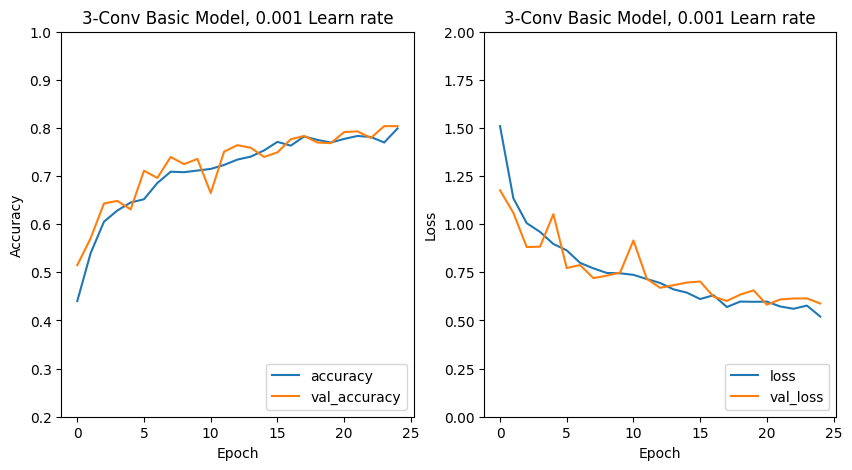

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history2.history['accuracy'], label='accuracy')
ax1.plot(history2.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.2, 1])
ax1.set_title('3-Conv Basic Model, 0.001 Learn rate')
ax1.legend(loc='lower right')

ax2.plot(history2.history['loss'], label='loss')
ax2.plot(history2.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2])
ax2.set_title('3-Conv Basic Model, 0.001 Learn rate')
ax2.legend(loc='lower right')

Increasing the learning rate did end up improving the final result (around 0.8 accuracy compared to around .75 with the slower rate), it still doesn't seem like it finished converging. It does seem like it was getting close though, so I want to try with a higher epoch count this time to see where it actually peaks.

In [143]:
LEARN_RATE = .001
optimizer3 = tf.keras.optimizers.Adam(LEARN_RATE)
basic_model.compile(loss='categorical_crossentropy',
             optimizer=optimizer3,
             metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, baseline=None)

history3 = basic_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint, early_stopping]
)

print("Completed")

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 506ms/step - accuracy: 0.3125 - loss: 3.1996 - val_accuracy: 0.5082 - val_loss: 1.1519
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 511ms/step - accuracy: 0.5240 - loss: 1.1625 - val_accuracy: 0.5790 - val_loss: 1.0293
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 511ms/step - accuracy: 0.5885 - loss: 1.0302 - val_accuracy: 0.6294 - val_loss: 0.9522
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 510ms/step - accuracy: 0.6214 - loss: 0.9748 - val_accuracy: 0.6444 - val_loss: 0.9379
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.6410 - loss: 0.9520 - val_accuracy: 0.6144 - val_loss: 0.9962
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 541ms/step - accuracy: 0.6357 - loss: 0.9027 - val_accuracy: 0.6798 - val_loss: 0.7797
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 499ms/step - accuracy: 0.6544 - loss: 0.8385 - val_accuracy: 0.6730 - val_loss: 0.8250
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 511ms/step - accuracy: 0.6815 - loss: 0.8092 - 

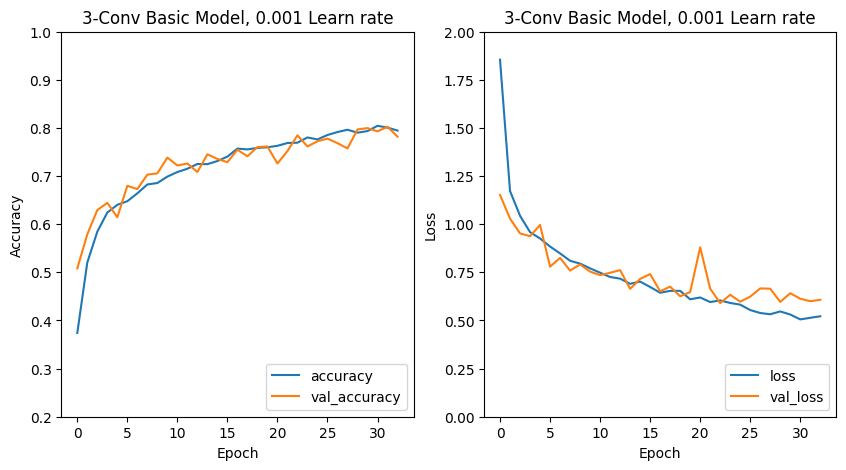

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history3.history['accuracy'], label='accuracy')
ax1.plot(history3.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.2, 1])
ax1.set_title('3-Conv Basic Model, 0.001 Learn rate')
ax1.legend(loc='lower right')

ax2.plot(history3.history['loss'], label='loss')
ax2.plot(history3.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2])
ax2.set_title('3-Conv Basic Model, 0.001 Learn rate')
ax2.legend(loc='lower right')

Early stopping ends up stopping the run at the 33rd epoch, so it seems like that's about where this model converges to (around 80% accuracy). The loss flattens out around .5, which arguably could be smaller, but at this point it seems unlikely I can make significant improvements just by adjusting the learning rate.

#### Model 2
For this model, I'm going to add a few extra features/layers. The difference in accuracy and validation accuracy is quite small, so I don't need to worry too much about overfitting. Instead, I want to focus on increasing the base accuracy. I'll start by trying to add a 4th convolution layer, as well as Batch Normalization to normalizae and hopefully accelerate the training process, along with L2 regularization to penalize larger weights that might be lowering the accuracy.

In [181]:
# Improved Model:
def layer4_CNN():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(5, activation='softmax')
    ])
    return model

layer4_model = layer4_CNN()
layer4_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963,397 (18.93 MB)

 Trainable params: 4,962,181 (18.93 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [176]:
history4 = fit_model(.001, 100, layer4_model)
print("Completed")

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 635ms/step - accuracy: 0.4495 - loss: 9.4016 - val_accuracy: 0.2439 - val_loss: 8.6175
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 636ms/step - accuracy: 0.5869 - loss: 4.7632 - val_accuracy: 0.2439 - val_loss: 5.2259
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.6023 - loss: 3.0862 - val_accuracy: 0.2698 - val_loss: 3.3992
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 640ms/step - accuracy: 0.6320 - loss: 2.3943 - val_accuracy: 0.3243 - val_loss: 2.8302
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 639ms/step - accuracy: 0.6331 - loss: 1.9608 - val_accuracy: 0.4019 - val_loss: 2.3712
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.6393 - loss: 1.7681 - val_accuracy: 0.4196 - val_loss: 2.1078
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 638ms/step - accuracy: 0.6503 - loss: 1.5992 - val_accuracy: 0.6499 - val_loss: 1.4948
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.6486 - loss: 1.4919 - 

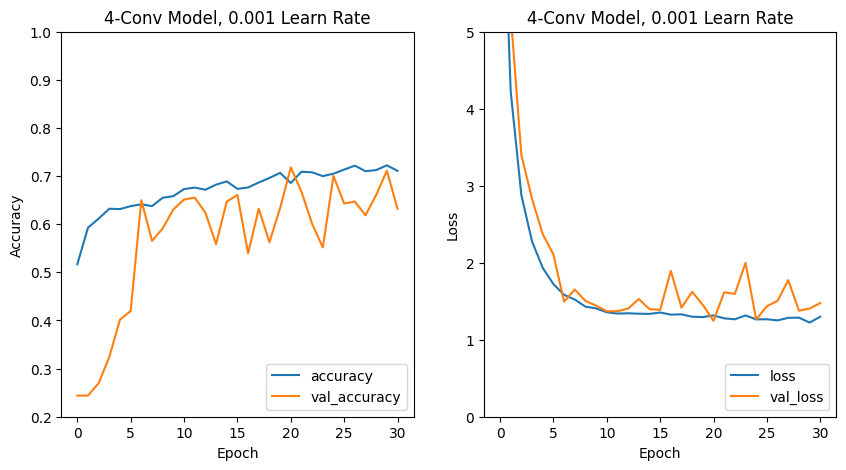

In [177]:
plot_stats(history4, "4-Conv Model, 0.001 Learn Rate", [.2, 1], [0, 5])

Looking at these stats, there's a few takeaways. One is that compared to the more "basic" model, the loss is significantly higher and flattens out, seeming to be stuck around 1.5. It converges to a much lower accuracy as well (.7 vs .8), which means I've likely overcomplicated the model and made things worse as a result. I want to try another run with a lower learning rate just to see if that makes a difference.

In [182]:
history5 = fit_model(.00025, 100, layer4_model)
print("Completed")

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 635ms/step - accuracy: 0.4706 - loss: 9.2022 - val_accuracy: 0.2439 - val_loss: 12.0889
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.6419 - loss: 7.6890 - val_accuracy: 0.2439 - val_loss: 11.7683
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 636ms/step - accuracy: 0.6858 - loss: 6.5431 - val_accuracy: 0.2439 - val_loss: 9.3066
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 636ms/step - accuracy: 0.6807 - loss: 5.6045 - val_accuracy: 0.2589 - val_loss: 7.2146
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 638ms/step - accuracy: 0.6853 - loss: 4.7737 - val_accuracy: 0.4837 - val_loss: 5.0190
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 639ms/step - accuracy: 0.7134 - loss: 4.1280 - val_accuracy: 0.6458 - val_loss: 3.8645
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 639ms/step - accuracy: 0.6952 - loss: 3.6496 - val_accuracy: 0.6812 - val_loss: 3.3791
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 636ms/step - accuracy: 0.7165 - loss: 3.1941 

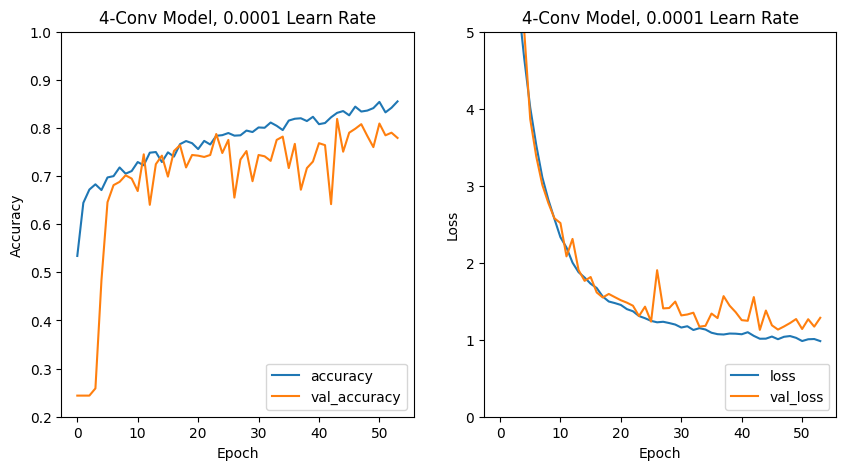

In [184]:
plot_stats(history5, "4-Conv Model, 0.0001 Learn Rate", [.2, 1], [0, 5])

Looking at the results here, lowering the learning rate does lead to an increase in training accuracy, higher than the first model (which peaked around .8 vs .85). However, while the validation accuracy is still higher than with the 0.001 learning rate, it 's diverging a bit from the training accuracy, which might be an indicator of overfitting. Either way, it doesn't seem like this model can improve much further.

### Model 3
For this model, I want to try using a pretrained model (in this case EfficientNetB3) to see how it performs in comparison to my own attempts.

In [189]:
enetb3_model = EfficientNetB3(include_top= False, weights='imagenet',
                           input_shape=(224, 224, 3), pooling='max')

pretrain_model = tf.keras.models.Sequential([
    enetb3_model,
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


In [ ]:
history6 = fit_model(.001, 100, pretrain_model)
print("Completed")

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.6539 - loss: 1.0887 - val_accuracy: 0.2439 - val_loss: 1.9076
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.8660 - loss: 0.4072 - val_accuracy: 0.2439 - val_loss: 2.2878
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.8787 - loss: 0.3910 - val_accuracy: 0.2439 - val_loss: 1.7416
Epoch 4/100
 8/92 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.9075 - loss: 0.4025

In [ ]:
plot_stats(history6, "EfficientNetB3 model, 0.001 Learn Rate", [.2, 1], [0, 5])

My first big takeaway is how much slower this runs compared to the models I made from scratch, likely owing to how much more complex this model is. At 3-4 minutes an epoch, I decided to not run this on my notebook and instead use Google Colab instead